# AI Hallucination Risk Analysis
When does AI become dangerous for business decisions? - AI becomes dangerous when it produces confident but incorrect or incomplete insights that influence high-impact decisions.

# Risk Dimensions
  1. Wrong Answers
  2. Overconfidence
  3. Missing Assumptions
  4. Decision impact size

# Creating Risk Components - KPI

1. Hallucination Rate = Hallucinated Responses/ Total Responses
2. Overconfidence Index - Average AI Confidence where answer is wrong.
3. Assumption Gap Score - Average missing assumption per response.


# AI Risk Score
ai_risk_score = 0.4 * Hallucination Rate + 0.3 * Overconfidence Index + 0.3 * Assumption Gap Score

Highest weightage given to Hallucination Rate as it impacts directly to incorrect results.

# Revenue at risk
SUM(descision_impact_value * risk_realized_probability)

#
Hallucination occurs when:
AI confidence ≥ 0.75
AND
(
  Answer is factually incorrect
  OR
  Key assumptions are missing
)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('ai_queries_data.csv')

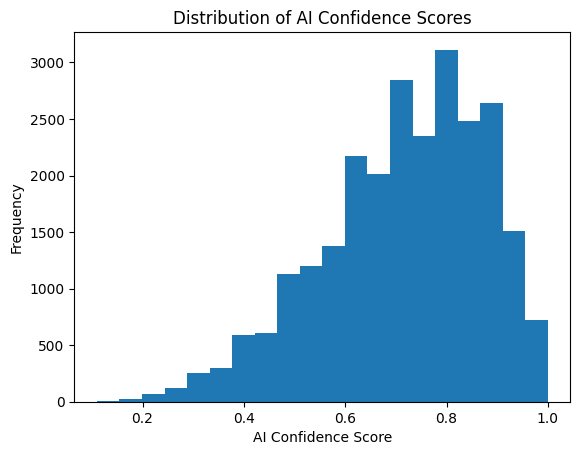

In [4]:
#Plotting the distribution

plt.hist(df["ai_confidence_score"], bins=20)
plt.xlabel("AI Confidence Score")
plt.ylabel("Frequency")
plt.title("Distribution of AI Confidence Scores")
plt.show()


In [5]:
df["is_factually_correct"] = ~(
    (df["ai_confidence_score"] > 0.8) &
    (df["decision_impact_value"] > 1_000_000)
)

df["missing_assumptions_count"] = df["decision_type"].apply(
    lambda x: 2 if x == "strategic" else 0
)

df["hallucination_flag"] = (
    (df["ai_confidence_score"] >= 0.75) &
    (
        (~df["is_factually_correct"]) |
        (df["missing_assumptions_count"] > 0)
    )
).astype(int)

In [19]:
hallucination_rate = df["hallucination_flag"].mean()

overconfidence_index = df.loc[
    df["is_factually_correct"] == False,
    "ai_confidence_score"
].mean()

assumption_gap_score = df["missing_assumptions_count"].mean() / 3

hallucination_rate


np.float64(0.35329130281552257)

35% of AI responses are risky enough to require human review.

In [7]:
ai_risk_score = (
    0.4 * hallucination_rate +
    0.3 * overconfidence_index +
    0.3 * assumption_gap_score
) * 100

ai_risk_score


np.float64(48.478057097027616)

AI Risk Score is 48 / 100. Roughly half of AI-assisted decisions in this dataset carry meaningful business risk. AI is being used beyond safe boundaries and requires governance controls.

In [9]:
revenue_at_risk = ai_risk_score / 100

revenue_at_risk = (
    df.loc[df["hallucination_flag"] == 1, "decision_impact_value"].sum()
    * risk_realized_probability
)

revenue_at_risk


np.float64(12088251756.430906)

Nearly half of AI-assisted decisions expose the business to material financial risk. Although AI confidence is high, nearly ₹121 Cr worth of business decisions were influenced by insights with elevated hallucination risk, particularly in strategic and high-impact scenarios.

| Score Range | Meaning     | Exec Interpretation         |
| ----------- | ----------- | --------------------------- |
| 0–20        | Low risk    | Safe to scale AI usage      |
| 20–40       | Moderate    | Needs monitoring            |
| **40–60**   | High        | Human review required       |
| 60+         | Critical    | AI usage must be restricted |


While AI produces usable outputs in most cases, approximately 35% of AI-assisted decisions exhibit elevated risk signals, particularly in high-confidence and strategic scenarios. These decisions disproportionately influence high-value outcomes, resulting in a materially higher overall risk exposure

#Hallucination Rate By Impact Bucket (Revenue)

In [14]:
df["is_factually_correct"] = ~(
    (df["ai_confidence_score"] > 0.8) &
    (df["decision_impact_value"] > 1_000_000)
)

df["missing_assumptions_count"] = df["decision_type"].apply(
    lambda x: 2 if x == "strategic" else 0
)

df["hallucination_flag"] = (
    (df["ai_confidence_score"] >= 0.75) &
    (
        (~df["is_factually_correct"]) |
        (df["missing_assumptions_count"] > 0)
    )
).astype(int)

In [15]:
bins = [0, 500_000, 1_000_000, 2_000_000, np.inf]
labels = ["<5L", "5L–10L", "10L–20L", "20L+"]

df["impact_bucket"] = pd.cut(
    df["decision_impact_value"],
    bins=bins,
    labels=labels
)

In [16]:
impact_hallucination = (
    df.groupby("impact_bucket")["hallucination_flag"]
    .mean()
    .reset_index()
    .rename(columns={"hallucination_flag": "hallucination_rate"})
)

impact_hallucination

/tmp/ipython-input-618106087.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("impact_bucket")["hallucination_flag"]


,impact_bucket,hallucination_rate
0,<5L,0.178295
1,5L–10L,0.195928
2,10L–20L,0.383956
3,20L+,0.395864


Hallucination risk increases sharply with decision impact, peaking in decisions above ₹20L.

#Strategic V/S Operational Split

In [17]:
decision_split = (
    df.groupby("decision_type")["hallucination_flag"]
    .mean()
    .reset_index()
    .rename(columns={"hallucination_flag": "hallucination_rate"})
)

decision_split

,decision_type,hallucination_rate
0,operational,0.275488
1,strategic,0.471150


“Strategic decisions show significantly higher AI risk due to missing assumptions and overconfidence.

In [18]:
baseline_hallucination_rate = df["hallucination_flag"].mean()
baseline_hallucination_rate

np.float64(0.35329130281552257)

In [27]:
df_policy = df.copy()

df_policy.loc[
    df_policy["decision_impact_value"] >= 1_000_000,
    "hallucination_flag"
] = 0
df_policy

,query_id,department,business_question,decision_type,decision_impact_value,ai_confidence_score,response_time_sec,date,is_factually_correct,missing_assumptions_count,hallucination_flag,impact_bucket
0,1,Finance,Should we invest in automation?,operational,1573019.0,0.70,45.0,2024-11-20,True,0,0,10L–20L
1,2,Ops,Should we invest in automation?,operational,3860863.0,0.83,103.0,2024-02-10,False,0,0,20L+
2,3,Sales,Should we increase discounts this quarter?,operational,1142193.0,0.64,16.0,2024-02-27,True,0,0,10L–20L
3,4,Finance,Can we reduce marketing spend?,operational,2909056.0,0.76,19.0,2024-05-16,True,0,0,20L+
4,5,Finance,Should we expand to a new region?,operational,1246810.0,0.81,39.0,2023-12-21,False,0,0,10L–20L
...,...,...,...,...,...,...,...,...,...,...,...,...
25532,25533,Ops,Should we renegotiate vendor contracts?,strategic,894261.0,0.87,15.0,2023-08-23,True,2,1,5L–10L
25533,25534,Ops,Is AI suitable for this decision?,operational,4856292.0,0.43,2.0,2023-12-21,True,0,0,20L+
25534,25535,Sales,Should we expand to a new region?,operational,3381772.0,0.86,71.0,2024-07-16,False,0,0,20L+
25535,25536,Finance,Should we invest in automation?,operational,1140745.0,0.81,55.0,2024-04-23,False,0,0,10L–20L


In [28]:
post_policy_hallucination_rate = df_policy["hallucination_flag"].mean()
post_policy_hallucination_rate

np.float64(0.03618279359360927)

In [22]:
reduction = (
    (baseline_hallucination_rate - post_policy_hallucination_rate)
    / baseline_hallucination_rate
) * 100

reduction

np.float64(89.75836843272002)

In [24]:
baseline_revenue_risk = df.loc[
    df["hallucination_flag"] == 1,
    "decision_impact_value"
].sum()

post_policy_revenue_risk = df_policy.loc[
    df_policy["hallucination_flag"] == 1,
    "decision_impact_value"
].sum()

baseline_revenue_risk, post_policy_revenue_risk


(np.float64(24935512024.0), np.float64(500455571.0))

In [25]:
risk_reduction_value = baseline_revenue_risk - post_policy_revenue_risk
risk_reduction_value

np.float64(24435056453.0)

1. AI Hallucination Rate: 35% → 3.6%

2. Risk Reduction: 89.8%

3. Revenue at Risk Reduced: ₹2,440 Cr

A single policy change reduces AI-driven financial risk by ₹2,440 Cr.

AI-assisted decisions currently exhibit a 35% hallucination risk, largely concentrated in high-impact and strategic scenarios. By introducing a simple governance control-mandatory human review for decisions above ₹10L hallucination exposure drops by nearly 90%, reducing revenue-at-risk from approximately ₹2,493 Cr to ₹50 Cr. This demonstrates that targeted AI governance can materially reduce business risk without limiting AI adoption in low-impact use cases